# 기존

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import Input
import sys,os,math,pathlib
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [2]:
batch_size = 32
split_percent=0.3
rand_seed=123
shuffle_num=1000
EPOCHS=100
dir_path = 'E:/##kpu_capstone_voice_data/##same_amount_voice/augment_bad_o(per_560)'

### 현재 데이터 클래스 1개 추가된 상태

In [3]:
data_dir = pathlib.Path(dir_path)
image_list = list(data_dir.glob('*/*.png'))
image_size = Image.open(image_list[0]).size
img_width=image_size[0]
img_height=image_size[1]

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent,
    subset="training",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3847 files belonging to 8 classes.
Using 2693 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent ,
    subset="validation",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3847 files belonging to 8 classes.
Using 1154 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_num).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [8]:
class_names  # 데이터 클래스가 1개 추가된 상태

['call_sangho',
 'good_morning',
 'how_working_path',
 'recommend_music',
 'today_weather',
 'tomorrow_weather',
 'tv_on',
 'youtube_dongbinna']

In [13]:
K = num_classes
input_tensor = Input(shape=(img_height, img_width, 3), dtype='float32', name='input')
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x) 
    return x    
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)      
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
            shortcut = x            
    return x
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x

def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)  # dense
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

resnet50.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 100, 130, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 100, 130, 64) 256         conv2d_53[0][0]                  
____________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 7, 9, 512)    2048        conv2d_97[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 7, 9, 512)    0           batch_normalization_97[0][0]     
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 7, 9, 2048)   1050624     activation_90[0][0]              
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 7, 9, 2048)   2099200     activation_88[0][0]              
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 7, 9, 2048)   8192        conv2d_98[0][0]                  
__________

In [14]:
with tf.device('/GPU:0'):
    history = resnet50.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
    )

Epoch 1/100
84/84 [==============================] - 103s 994ms/step - loss: 2.7285 - accuracy: 0.2283 - val_loss: 2.4087 - val_accuracy: 0.2005
Epoch 2/100
84/84 [==============================] - 64s 750ms/step - loss: 1.1532 - accuracy: 0.5959 - val_loss: 9.2917 - val_accuracy: 0.1480
Epoch 3/100
84/84 [==============================] - 64s 746ms/step - loss: 0.6257 - accuracy: 0.7830 - val_loss: 2.4826 - val_accuracy: 0.5044
Epoch 4/100
84/84 [==============================] - 64s 748ms/step - loss: 0.4527 - accuracy: 0.8529 - val_loss: 14.9423 - val_accuracy: 0.1620
Epoch 5/100
84/84 [==============================] - 64s 746ms/step - loss: 0.2701 - accuracy: 0.9081 - val_loss: 7.3444 - val_accuracy: 0.3958
Epoch 6/100
84/84 [==============================] - 64s 746ms/step - loss: 0.1991 - accuracy: 0.9330 - val_loss: 6.7340 - val_accuracy: 0.4299
Epoch 7/100
84/84 [==============================] - 63s 745ms/step - loss: 0.0941 - accuracy: 0.9642 - val_loss: 0.3217 - val_accurac

In [17]:
# 기존
from keras.models import load_model
test = load_model('E:/##kpu_capstone_voice_data/##model/resnet50_model_9_06(denoise(o), augment(o), bad, batch=32,size=(260x200),origin_spec(0.3)-epoch=130).h5')

INFO:tensorflow:Assets written to: E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk3-2.tf\assets


### 변경사항

In [9]:
# save_format='tf' 로 저장
from keras.models import load_model
resnet50.save('E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk3-2', save_format='tf')

In [9]:
# tf model 로 load
from keras.models import load_model
test_model = load_model('E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk4')

In [14]:
# 이어학습
EPOCHS = 5
with tf.device('/GPU:0'):
    history = test_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
    )

Epoch 1/5
85/85 [==============================] - 99s 865ms/step - loss: nan - accuracy: 0.1515 - val_loss: nan - val_accuracy: 0.1386
Epoch 2/5
85/85 [==============================] - 49s 574ms/step - loss: nan - accuracy: 0.1426 - val_loss: nan - val_accuracy: 0.1386
Epoch 3/5
85/85 [==============================] - 49s 578ms/step - loss: nan - accuracy: 0.1426 - val_loss: nan - val_accuracy: 0.1386
Epoch 4/5
85/85 [==============================] - 49s 577ms/step - loss: nan - accuracy: 0.1426 - val_loss: nan - val_accuracy: 0.1386
Epoch 5/5
85/85 [==============================] - 49s 577ms/step - loss: nan - accuracy: 0.1426 - val_loss: nan - val_accuracy: 0.1386


In [15]:
# 저장
test_model.save('E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk4', save_format='tf')

INFO:tensorflow:Assets written to: E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk4\assets


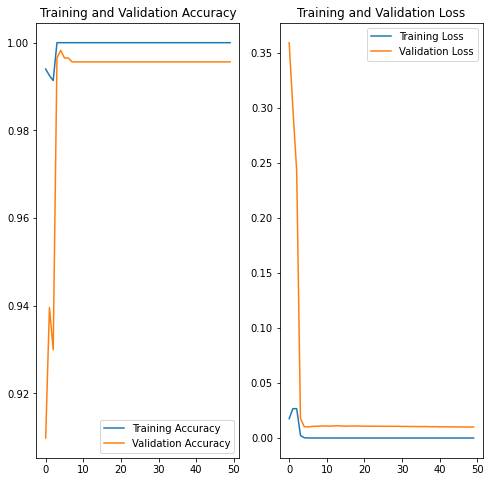

In [16]:
# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [4]:
img_height = 200
img_width = 260

In [9]:
# 모델 체크
from keras.preprocessing import image
image_path = "E:/##kpu_capstone_voice_data/##same_amount_voice/#augment_bad_o(per_560)_validation/good_morning/denoisedgood_morning (1).png2.png"
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
#print(img_array)
predictions = test.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)
print("새로운 데이터는  클래스일 확률이 {:.2f}%입니다..".format( 100 * np.max(score)))

[[1.0540477e-08 9.9999893e-01 1.5703183e-10 3.2211886e-07 1.0118249e-08
  4.1645634e-08 6.3862365e-07]]
tf.Tensor(
[0.11470153 0.31179073 0.11470153 0.11470156 0.11470153 0.11470153
 0.11470161], shape=(7,), dtype=float32)
새로운 데이터는  클래스일 확률이 31.18%입니다..


# 새로운 클래스 추가

### 모델 구조 변경

### test.layers.pop()  # dense 레이어 삭제 --> 안 됨

In [11]:
# 모델명: test, weights_bak: 기존 weight 얻기, nb_classes: 기존 class 얻기

from keras.layers import Dense
import numpy as np

# 기존 모델 weight backup
weights_bak = test_model.layers[-1].get_weights()
print(weights_bak)
nb_classes = test_model.layers[-1].output_shape[-1]
print(nb_classes)

[array([[ 0.04466043,  0.06946582, -0.08502575, ..., -0.10097951,
        -0.02636709,  0.04760658],
       [ 0.03575062,  0.04620038, -0.04354549, ..., -0.15197016,
         0.09539365,  0.00958034],
       [-0.02776275,  0.00696695,  0.06661399, ..., -0.00194581,
        -0.06024632, -0.01319455],
       ...,
       [-0.00145594,  0.05222666, -0.00341785, ..., -0.06290363,
        -0.02085103, -0.03717859],
       [-0.0664552 ,  0.02215029, -0.02771749, ...,  0.01322677,
        -0.0533746 ,  0.0528442 ],
       [ 0.02751628, -0.12613268, -0.01807615, ..., -0.02604857,
         0.00124519,  0.08939798]], dtype=float32), array([-0.00420483,  0.02200897, -0.00564838,  0.00252645, -0.00521261,
       -0.00827783, -0.00827766], dtype=float32)]
7


In [13]:
test_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 100, 130, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 100, 130, 64) 256         conv2d_53[0][0]                  
____________________________________________________________________________________________

activation_87 (Activation)      (None, 13, 17, 256)  0           batch_normalization_94[0][0]     
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 13, 17, 1024) 263168      activation_87[0][0]              
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 13, 17, 1024) 4096        conv2d_95[0][0]                  
__________________________________________________________________________________________________
add_28 (Add)                    (None, 13, 17, 1024) 0           batch_normalization_95[0][0]     
                                                                 activation_85[0][0]              
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 13, 17, 1024) 0           add_28[0][0]                     
__________

In [51]:
test_model.layers.pop()  # dense 레이어 삭제 --> 안 됨

# model2= test(inputs=test.input, outputs=test.layers[-2].output)
# output_tensor = Dense(K, activation='softmax')(x)
print(test_model.input)
print(test_model.output)
print(test_model.layers[-2].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 260, 3), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='global_average_pooling2d_1/Mean:0', description="created by layer 'global_average_pooling2d_1'")


In [49]:
# 총 레이어 확인
testx = test.layers
testx

In [68]:
# dense 층 재생성 확인
Dense(nb_classes+1, activation='softmax')(test.layers[-2].output)

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'dense_12')>

In [16]:
# pop dense layer
model2 = Model(inputs=test_model.input, outputs=test_model.layers[-2].output)
model2.summary()

# print(model2.input)

# push dense layer
model3 = Model(inputs=model2.input, outputs=Dense(num_classes, activation='softmax')(test_model.layers[-2].output))
model3.summary()

# model2 = Model(inputs=model2.input, outputs=Dense(num_classes, activation='softmax').output)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 100, 130, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 100, 130, 64) 256         conv2d_53[0][0]                  
____________________________________________________________________________________________

Non-trainable params: 53,120
__________________________________________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 100, 130, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 100, 130, 64) 256       

__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 13, 17, 1024) 4096        conv2d_83[0][0]                  
__________________________________________________________________________________________________
add_24 (Add)                    (None, 13, 17, 1024) 0           batch_normalization_83[0][0]     
                                                                 activation_73[0][0]              
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 13, 17, 1024) 0           add_24[0][0]                     
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 13, 17, 256)  262400      activation_76[0][0]              
__________________________________________________________________________________________________
batch_norm

In [50]:
# 모델 컴파일
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
# 기존 모델 weight 체크
print(weights_bak)
# 새로운 모델 weight 저장
weights_new = model3.layers[-1].get_weights()
weights_new

[array([[ 0.04466043,  0.06946582, -0.08502575, ..., -0.10097951,
        -0.02636709,  0.04760658],
       [ 0.03575062,  0.04620038, -0.04354549, ..., -0.15197016,
         0.09539365,  0.00958034],
       [-0.02776275,  0.00696695,  0.06661399, ..., -0.00194581,
        -0.06024632, -0.01319455],
       ...,
       [-0.00145594,  0.05222666, -0.00341785, ..., -0.06290363,
        -0.02085103, -0.03717859],
       [-0.0664552 ,  0.02215029, -0.02771749, ...,  0.01322677,
        -0.0533746 ,  0.0528442 ],
       [ 0.02751628, -0.12613268, -0.01807615, ..., -0.02604857,
         0.00124519,  0.08939798]], dtype=float32), array([-0.00420483,  0.02200897, -0.00564838,  0.00252645, -0.00521261,
       -0.00827783, -0.00827766], dtype=float32)]


[array([[ 0.04466043,  0.06946582, -0.08502575, ..., -0.02636709,
          0.04760658, -0.01142132],
        [ 0.03575062,  0.04620038, -0.04354549, ...,  0.09539365,
          0.00958034, -0.00042271],
        [-0.02776275,  0.00696695,  0.06661399, ..., -0.06024632,
         -0.01319455, -0.00639524],
        ...,
        [-0.00145594,  0.05222666, -0.00341785, ..., -0.02085103,
         -0.03717859, -0.00961926],
        [-0.0664552 ,  0.02215029, -0.02771749, ..., -0.0533746 ,
          0.0528442 , -0.01228867],
        [ 0.02751628, -0.12613268, -0.01807615, ...,  0.00124519,
          0.08939798, -0.01069544]], dtype=float32),
 array([-0.00420483,  0.02200897, -0.00564838,  0.00252645, -0.00521261,
        -0.00827783, -0.00827766, -0.00101227], dtype=float32)]

### 크기 확인

In [23]:
weights_new[0][:, :-1].shape

(2048, 7)

In [20]:
weights_bak[0].shape

(2048, 7)

In [52]:
bound = "====================================================================="
weights_new[0][:, :-1] = weights_bak[0]
print("{} \n {} \n {}".format(weights_new[0][:, :-1], bound, weights_bak[0]))

[[ 0.04466043  0.06946582 -0.08502575 ... -0.10097951 -0.02636709
   0.04760658]
 [ 0.03575062  0.04620038 -0.04354549 ... -0.15197016  0.09539365
   0.00958034]
 [-0.02776275  0.00696695  0.06661399 ... -0.00194581 -0.06024632
  -0.01319455]
 ...
 [-0.00145594  0.05222666 -0.00341785 ... -0.06290363 -0.02085103
  -0.03717859]
 [-0.0664552   0.02215029 -0.02771749 ...  0.01322677 -0.0533746
   0.0528442 ]
 [ 0.02751628 -0.12613268 -0.01807615 ... -0.02604857  0.00124519
   0.08939798]] 
 [[ 0.04466043  0.06946582 -0.08502575 ... -0.10097951 -0.02636709
   0.04760658]
 [ 0.03575062  0.04620038 -0.04354549 ... -0.15197016  0.09539365
   0.00958034]
 [-0.02776275  0.00696695  0.06661399 ... -0.00194581 -0.06024632
  -0.01319455]
 ...
 [-0.00145594  0.05222666 -0.00341785 ... -0.06290363 -0.02085103
  -0.03717859]
 [-0.0664552   0.02215029 -0.02771749 ...  0.01322677 -0.0533746
   0.0528442 ]
 [ 0.02751628 -0.12613268 -0.01807615 ... -0.02604857  0.00124519
   0.08939798]]


In [53]:
weights_new[1][:-1] = weights_bak[1]
print("{} \n {} \n {}".format(weights_new[1][:-1], bound, weights_bak[1]))

[-0.00420483  0.02200897 -0.00564838  0.00252645 -0.00521261 -0.00827783
 -0.00827766] 
 [-0.00420483  0.02200897 -0.00564838  0.00252645 -0.00521261 -0.00827783
 -0.00827766]


In [54]:
weights_new[0][:, -1] = np.mean(weights_bak[0], axis=1)
weights_new[1][-1] = np.mean(weights_bak[1])

In [55]:
model3.layers[-1].set_weights(weights_new)
model3.layers[-1].get_weights()

[array([[ 0.04466043,  0.06946582, -0.08502575, ..., -0.02636709,
          0.04760658, -0.01142132],
        [ 0.03575062,  0.04620038, -0.04354549, ...,  0.09539365,
          0.00958034, -0.00042271],
        [-0.02776275,  0.00696695,  0.06661399, ..., -0.06024632,
         -0.01319455, -0.00639524],
        ...,
        [-0.00145594,  0.05222666, -0.00341785, ..., -0.02085103,
         -0.03717859, -0.00961926],
        [-0.0664552 ,  0.02215029, -0.02771749, ..., -0.0533746 ,
          0.0528442 , -0.01228867],
        [ 0.02751628, -0.12613268, -0.01807615, ...,  0.00124519,
          0.08939798, -0.01069544]], dtype=float32),
 array([-0.00420483,  0.02200897, -0.00564838,  0.00252645, -0.00521261,
        -0.00827783, -0.00827766, -0.00101227], dtype=float32)]

In [56]:
EPOCHS = 10
with tf.device('/GPU:0'):
    history = model3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
    )

Epoch 1/10
85/85 [==============================] - 98s 899ms/step - loss: 0.7852 - accuracy: 0.9279 - val_loss: 0.1175 - val_accuracy: 0.9610
Epoch 2/10
85/85 [==============================] - 50s 592ms/step - loss: 0.0165 - accuracy: 0.9969 - val_loss: 0.0768 - val_accuracy: 0.9783
Epoch 3/10
85/85 [==============================] - 50s 591ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9948
Epoch 4/10
85/85 [==============================] - 50s 592ms/step - loss: 8.8812e-04 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9957
Epoch 5/10
85/85 [==============================] - 50s 592ms/step - loss: 6.6020e-04 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 0.9965
Epoch 6/10
85/85 [==============================] - 50s 590ms/step - loss: 4.3420e-04 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9965
Epoch 7/10
85/85 [==============================] - 50s 589ms/step - loss: 3.3970e-04 - accuracy: 1.0000 - val_loss: 0.0180 - val_

In [59]:
# 저장
model3.save('E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, addclass, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk5', save_format='tf')

INFO:tensorflow:Assets written to: E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, addclass, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk5\assets


In [7]:
test = load_model('E:/##kpu_capstone_voice_data/##model/resnet50_model_9_07(denoise(o), augment(o), bad, addclass, batch=32,size=(260x200),origin_spec(0.3)-epoch=130)mk5')

In [51]:
# 모델 체크
from keras.preprocessing import image
image_path = "E:\##kpu_capstone_voice_data/##same_amount_voice/#augment_bad_o(per_560)_validation/youtube_dongbinna/mung_dongbinna (1).png_denoised.png1_augment.png"
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
#print(img_array)
predictions = test.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)
print("새로운 데이터는 {} 클래스일 확률이 {:.2f}%입니다..".format(class_names[np.argmax(score)], 100 * np.max(score)))

FileNotFoundError: [Errno 2] No such file or directory: 'E:/##kpu_capstone_voice_data/##same_amount_voice/#augment_bad_o(per_560)_validation/yotube_dongbinna/mung_dongbinna (1).png_denoised.png1_augment.png'